**#Analysis and Prediction of Player Behavior in iGaming.**

In [35]:
pip install --upgrade scikit-learn


In [36]:
pip install pandas matplotlib seaborn scikit-learn lifetimes

##Carga y limpieza de datos

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
#cargar datos
df = pd.read_csv('/content/drive/MyDrive/IGaming.csv')

In [40]:
# Explorar los datos
print(df.head())
print(df.info())
print(df.describe())

    year  month  site_id market registrations  ftds active_players  \
0  2,023      2        1     AR            0      0             0    
1  2,023      2        1     AT             0     0             2    
2  2,023      2        1     BG            6      0             1    
3  2,023      2        1     BR        2,744    478           660    
4  2,023      2        1     CA          146     40           141    

  deposit_count unique_depositors  sports_active_players  ... casino_ggr_eur  \
0            0                 0                       0  ...              0   
1           46                 2                       2  ...              0   
2            2                 1                       0  ...            85    
3        1,909               571                     197  ...        20,321    
4          583               102                      88  ...        11,350    

   casino_bonus_issued_eur casino_bonus_withdrawn_eur casino_ngr_eur  \
0                        0

In [41]:
# Exploración de los datos
print(df.head())
print(df.info())
print(df.describe())

    year  month  site_id market registrations  ftds active_players  \
0  2,023      2        1     AR            0      0             0    
1  2,023      2        1     AT             0     0             2    
2  2,023      2        1     BG            6      0             1    
3  2,023      2        1     BR        2,744    478           660    
4  2,023      2        1     CA          146     40           141    

  deposit_count unique_depositors  sports_active_players  ... casino_ggr_eur  \
0            0                 0                       0  ...              0   
1           46                 2                       2  ...              0   
2            2                 1                       0  ...            85    
3        1,909               571                     197  ...        20,321    
4          583               102                      88  ...        11,350    

   casino_bonus_issued_eur casino_bonus_withdrawn_eur casino_ngr_eur  \
0                        0

In [42]:
# Eliminar espacios en blanco y convertir a string
df['year'] = df['year'].astype(str).str.strip()
df['month'] = df['month'].astype(str).str.strip()

# Reemplazar caracteres no numéricos (ejemplo: comas o espacios extras)
df['year'] = df['year'].str.replace(r'[^0-9]', '', regex=True)
df['month'] = df['month'].str.replace(r'[^0-9]', '', regex=True)

# Convertir 'month' a dos dígitos (ejemplo: 2 → 02)
df['month'] = df['month'].str.zfill(2)

# Crear la fecha correctamente
df['date'] = pd.to_datetime(df['year'] + '-' + df['month'] + '-01', format='%Y-%m-%d')

In [43]:
# Convertir fechas
df['year'] = df['year'].astype(str)
df['month'] = df['month'].astype(str)
df['date'] = pd.to_datetime(df['year'] + '-' + df['month'] + '-01')

In [44]:
print(df[['registrations', 'ftds']].dtypes)  # Verifica los tipos de datos
print(df[['registrations', 'ftds']].isnull().sum())  # Cuenta valores nulos
print(df[df['registrations'] == 0])  # Verifica si hay registros con 0


registrations    object
ftds              int64
dtype: object
registrations    0
ftds             0
dtype: int64
Empty DataFrame
Columns: [year, month, site_id, market, registrations, ftds, active_players, deposit_count, unique_depositors, sports_active_players, casino_active_players, live_casino_active_players, turnover_eur, winnings_eur, ggr_eur, withdrawal_adjustments_eur, deposit_adjustments_eur, bonus_withdrawn_eur, bonus_issued_eur, cashback_eur, goodwill_amount_eur, ngr_eur, deposits_eur, ftd_amount_eur, reload_amount_eur, withdrawals_eur, net_deposits_eur, sports_turnover_eur, sports_winnings_eur, sports_ggr_eur, sports_bonus_issued_eur, sports_bonus_withdrawn_eur, sports_ngr_eur, casino_turnover_eur, casino_winnings_eur, casino_ggr_eur, casino_bonus_issued_eur, casino_bonus_withdrawn_eur, casino_ngr_eur, live_casino_turnover_eur, live_casino_winnings_eur, live_casino_ggr_eur, live_casino_ngr_eur, vip_bonus_eur, total_bonus_eur, date]
Index: []

[0 rows x 46 columns]


In [45]:
# Asegurar que los valores sean numéricos
df['registrations'] = pd.to_numeric(df['registrations'], errors='coerce').fillna(0)
df['ftds'] = pd.to_numeric(df['ftds'], errors='coerce').fillna(0)

# Agrupar por mercado
ftd_conversion = df.groupby('market')[['registrations', 'ftds']].sum()

# Evitar divisiones por 0 reemplazando con un valor muy pequeño
ftd_conversion['conversion_rate'] = (ftd_conversion['ftds'] / ftd_conversion['registrations'].replace(0, 1)) * 100

# Mostrar resultados
print(ftd_conversion.head(10))


        registrations  ftds  conversion_rate
market                                      
AM                1.0     0         0.000000
AR                5.0     0         0.000000
AT                0.0     0         0.000000
BG               14.0     0         0.000000
BH                0.0     0         0.000000
BR                0.0  1723    172300.000000
CA              469.0   134        28.571429
CH                0.0     0         0.000000
CL             1012.0   222        21.936759
DE                0.0     0         0.000000


In [46]:
print(df[['registrations', 'ftds']].dtypes)  # Verifica los tipos de datos
print(df[['registrations', 'ftds']].isnull().sum())  # Cuenta valores nulos
print(df[df['registrations'] == 0])  # Verifica si hay registros con 0

registrations    float64
ftds               int64
dtype: object
registrations    0
ftds             0
dtype: int64
    year month  site_id market  registrations  ftds active_players  \
0   2023    02        1     AR            0.0     0             0    
1   2023    02        1     AT            0.0     0             2    
3   2023    02        1     BR            0.0   478           660    
5   2023    02        1     CH            0.0     0             0    
8   2023    02        1     HU            0.0     0              0   
9   2023    02        1     IE            0.0     0             1    
12  2023    02        1     NG            0.0     0              0   
19  2023    03        1     AM            0.0     0             0    
21  2023    03        1     AT            0.0     0             2    
23  2023    03        1     BR            0.0   585           768    
25  2023    03        1     CH            0.0     0             0    
27  2023    03        1     DE            0.0

##Análisis y retención de usuarios


In [47]:
# Análisis de Conversión
ftd_conversion = df.groupby('market')[['registrations', 'ftds']].sum()
ftd_conversion['conversion_rate'] = (ftd_conversion['ftds'] / ftd_conversion['registrations']) * 100

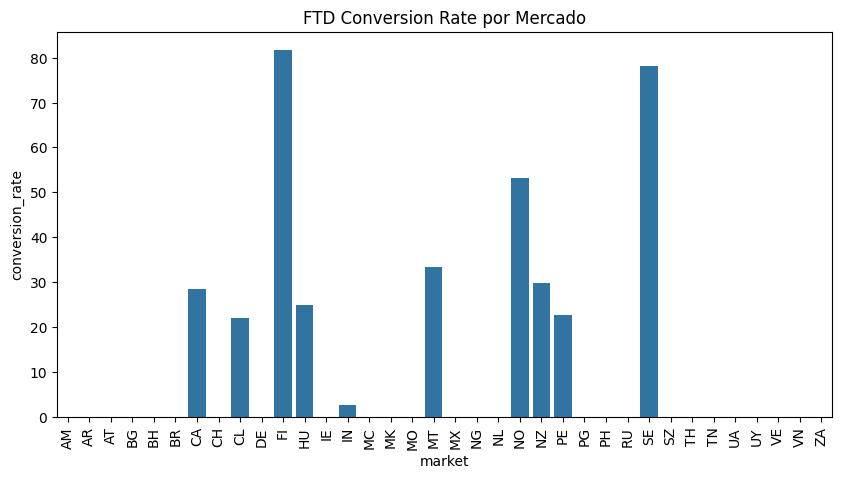

In [48]:
# Visualización de Conversión
plt.figure(figsize=(10, 5))
sns.barplot(data=ftd_conversion.reset_index(), x='market', y='conversion_rate')
plt.xticks(rotation=90)
plt.title('FTD Conversion Rate por Mercado')
plt.show()

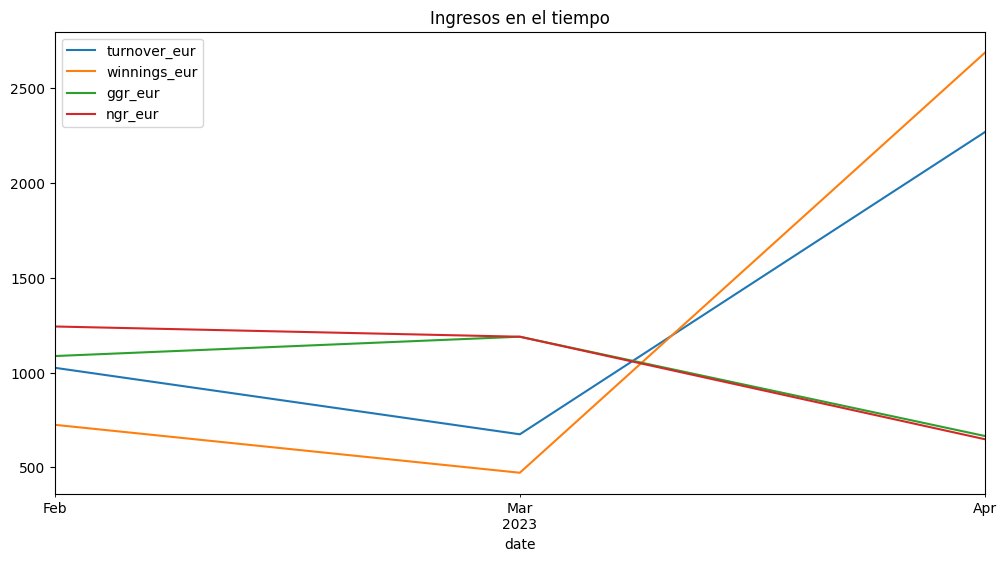

In [49]:
# Convertir a números y reemplazar NaN con 0
cols = ['turnover_eur', 'winnings_eur', 'ggr_eur', 'ngr_eur']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Agrupar por fecha y sumar
financials = df.groupby('date')[cols].sum()

# Graficar los datos
financials.plot(figsize=(12, 6), title='Ingresos en el tiempo')
plt.show()

##Segmentación de jugadores

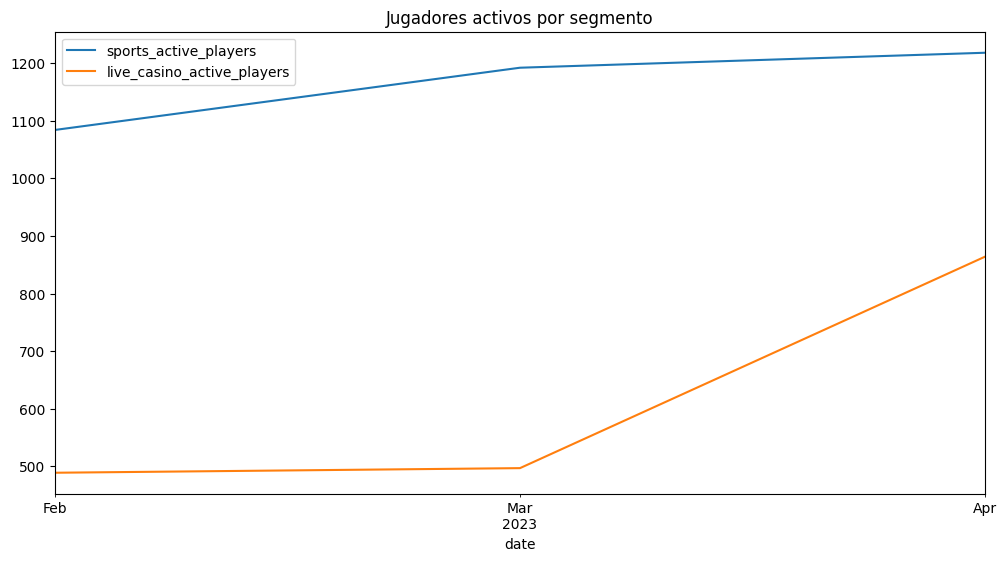

In [50]:
# Segmentación de jugadores
players = df.groupby('date')[['sports_active_players', 'casino_active_players', 'live_casino_active_players']].sum()
players.plot(figsize=(12, 6), title='Jugadores activos por segmento')
plt.show()

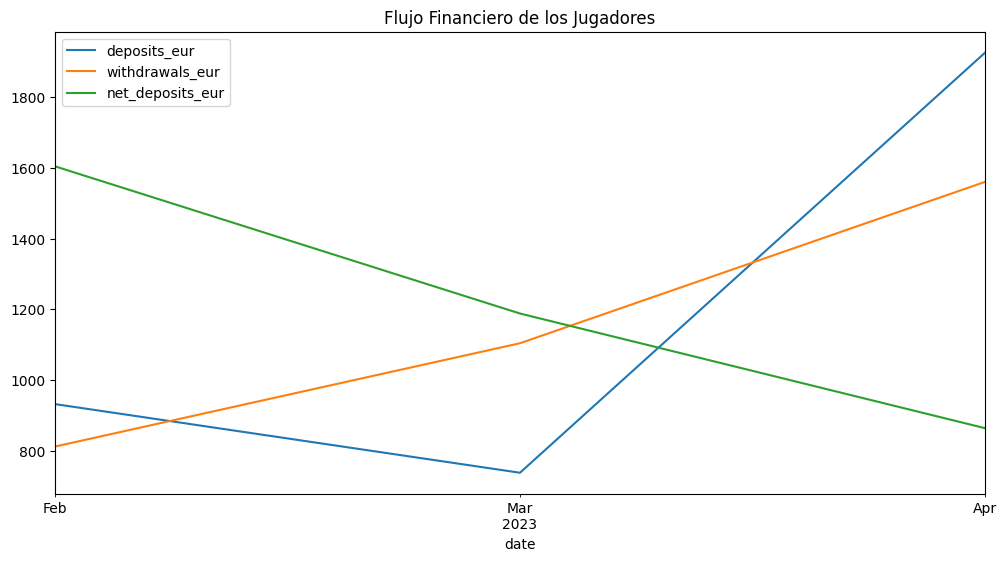

In [51]:
# Convertir a números y reemplazar NaN con 0
cols = ['deposits_eur', 'withdrawals_eur', 'net_deposits_eur']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Agrupar por fecha y sumar
deposits = df.groupby('date')[cols].sum()

# Verificar si hay datos después de la agregación
if deposits.empty:
    print("No hay datos disponibles para graficar.")
else:
    # Graficar los datos
    deposits.plot(figsize=(12, 6), title='Flujo Financiero de los Jugadores')
    plt.show()


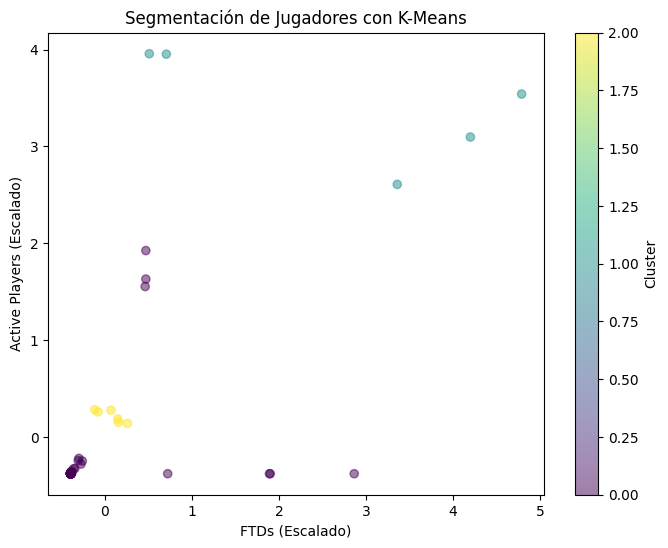

In [52]:
# Asegurar que las columnas sean numéricas
cols = ['ftds', 'active_players', 'deposit_count', 'withdrawals_eur']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# Escalar los datos
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df[cols])

# Aplicar KMeans con 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Graficar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=df['cluster'], cmap='viridis', alpha=0.5)
plt.xlabel('FTDs (Escalado)')
plt.ylabel('Active Players (Escalado)')
plt.title('Segmentación de Jugadores con K-Means')
plt.colorbar(label="Cluster")
plt.show()


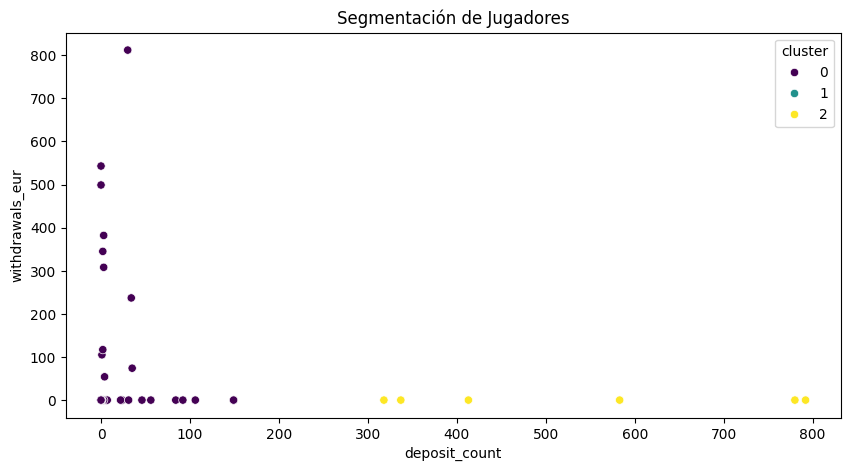

In [53]:
# Visualización de clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['deposit_count'], y=df['withdrawals_eur'], hue=df['cluster'], palette='viridis')
plt.title('Segmentación de Jugadores')
plt.show()

##Modelos de predicción

MAE: 58.66
MSE: 4020.13
R²: -0.82


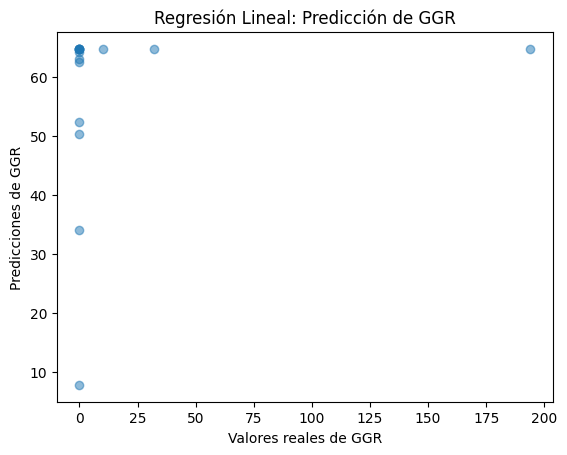

In [54]:
# Definir variables predictoras (X) y variable objetivo (y)
X = df[['ftds', 'active_players', 'deposit_count', 'withdrawals_eur']]
y = df['ggr_eur']

# Asegurar que los datos sean numéricos y eliminar NaN
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.to_numeric(y, errors='coerce').fillna(0)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# Visualizar resultados
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valores reales de GGR")
plt.ylabel("Predicciones de GGR")
plt.title("Regresión Lineal: Predicción de GGR")
plt.show()


MAE: 58.66
MSE: 4020.13
R²: -0.82


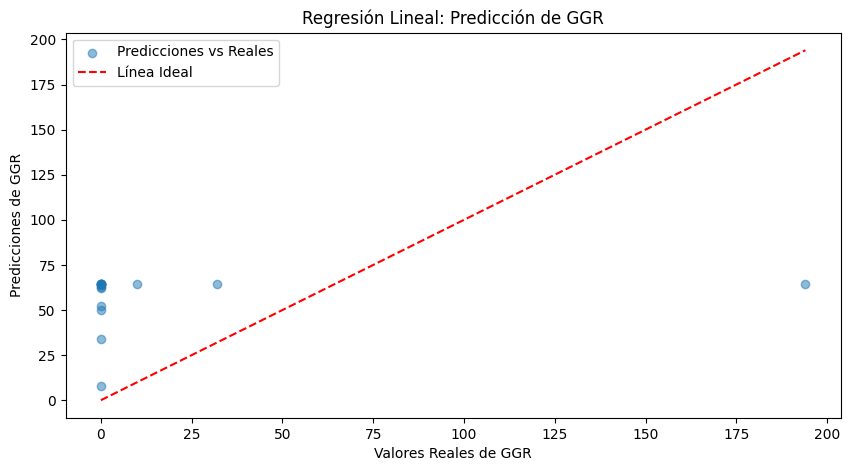

In [55]:
# Definir variables predictoras (X) y variable objetivo (y)
X = df[['ftds', 'active_players', 'deposit_count', 'withdrawals_eur']]
y = df['ggr_eur']

# Asegurar que los datos sean numéricos y eliminar NaN
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = pd.to_numeric(y, errors='coerce').fillna(0)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Generar predicciones
predictions = model.predict(X_test)

# Evaluación del modelo con métricas
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

# 📊 Visualización de resultados
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions, alpha=0.5, label="Predicciones vs Reales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label="Línea Ideal")
plt.xlabel("Valores Reales de GGR")
plt.ylabel("Predicciones de GGR")
plt.title("Regresión Lineal: Predicción de GGR")
plt.legend()
plt.show()
